In [88]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow import keras
from keras.layers import SimpleRNN, Input, Dense, Attention, MultiHeadAttention, Flatten
from keras.models import Sequential, Model
from keras.optimizers import Adam
import random as rd

In [3]:
dfs = [] 
directorio = './dataset_coordinador_electrico/T28052_CNANCUAN_2017-2023/'
csv_files = [f for f in os.listdir(directorio) if f.endswith('.csv')]
for csv in csv_files:
    ruta = os.path.join(directorio, csv)
    df = pd.read_csv(ruta, sep=';', names=['id','fecha','consumo','calidad','muestras','nombre'])
    dfs.append(df)

data = pd.concat(dfs, axis=0, ignore_index=True)


In [4]:
data.head()

,id,fecha,consumo,calidad,muestras,nombre
0,177760211,2022-03-01 00:00:00-0300,-8.458754,1,4,AJAHUEL 110 H1 P
1,395102211,2022-03-01 00:00:00-0300,-168.352138,1,4,BUIN 110 HT1 MTP
2,395684211,2022-03-01 00:00:00-0300,93.961443,1,4,BUIN 110 H2 P
3,397670211,2022-03-01 00:00:00-0300,27.799431,1,4,LOSALME 110 H1 P
4,397693211,2022-03-01 00:00:00-0300,55.301902,1,4,LOSALME 110 H3 P


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2242968 entries, 0 to 2242967
Data columns (total 6 columns):
 #   Column    Dtype  
---  ------    -----  
 0   id        int64  
 1   fecha     object 
 2   consumo   float64
 3   calidad   int64  
 4   muestras  int64  
 5   nombre    object 
dtypes: float64(1), int64(3), object(2)
memory usage: 102.7+ MB


Hay que unir los interruptores por comuna, sumando el consumo de estos.

In [6]:
data['nombre'].value_counts()

nombre
AJAHUEL   110  H1     P          57512
CNAVIA    110  H8     P          57512
AJAHUEL   110  H5     P          57512
AJAHUEL   110  H6     P          57512
CNAVIA    110  H4     P          57512
CNAVIA    110  H3     P          57512
CNAVIA    110  H6     P          57512
CNAVIA    110  H5     P          57512
CNAVIA    110  H7     P          57512
AJAHUEL   110  H2     P          57512
FLORIDA   110  H7     P          57512
CNAVIA    110  H9     P          57512
FLORIDA   110  H1     P          57512
FLORIDA   110  H2     P          57512
FLORIDA   110  H3     P          57512
FLORIDA   110  H4     P          57512
FLORIDA   110  H8     P          57512
FLORIDA   110  H9     P          57512
FLORIDA   110  H6     P          57512
CHENA     110  HT1    MTP        57512
BUIN      110  HT1    MTP        57512
CHENA     110  H2     P          57512
BUIN      110  H2     P          57512
LOSALME   110  H1     P          57512
LOSALME   110  H3     P          57512
LOSALME   110  H4 

In [7]:
data['nombre'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 2242968 entries, 0 to 2242967
Series name: nombre
Non-Null Count    Dtype 
--------------    ----- 
2242968 non-null  object
dtypes: object(1)
memory usage: 17.1+ MB


In [8]:
data['muestras'].value_counts()

muestras
4    2197793
0      26129
3      11299
2       5282
1       2465
Name: count, dtype: int64

In [9]:
data['calidad'].value_counts()

calidad
1     2197157
0       45175
33        636
Name: count, dtype: int64

In [10]:
data['fecha'].value_counts()

fecha
2022-03-01 00:00:00-0300    78
2022-05-01 10:00:00-0400    78
2022-05-01 04:00:00-0400    78
2022-05-01 05:00:00-0400    78
2022-05-01 06:00:00-0400    78
                            ..
2018-02-09 02:00:00-0300    39
2018-02-09 03:00:00-0300    39
2018-02-09 04:00:00-0300    39
2018-02-09 05:00:00-0300    39
2022-02-28 23:00:00-0300    39
Name: count, Length: 55303, dtype: int64

In [11]:
data['consumo'].describe()

count    2.242968e+06
mean     3.233541e+01
std      7.411118e+01
min     -5.970000e+02
25%     -3.062436e+00
50%      4.379763e+01
75%      8.145555e+01
max      3.199903e+02
Name: consumo, dtype: float64

<Axes: ylabel='consumo'>

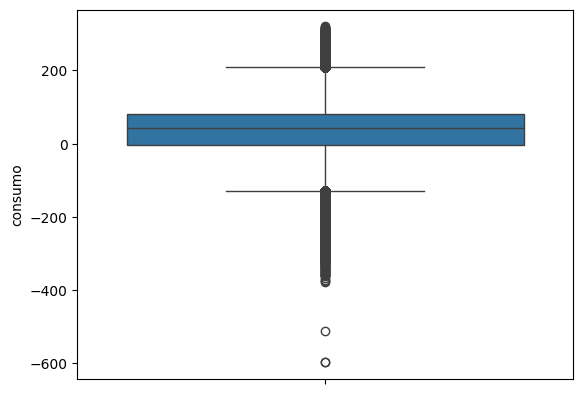

In [12]:
sns.boxplot(data['consumo'])

(array([3.000000e+00, 0.000000e+00, 4.200000e+01, 1.843000e+04,
        7.174600e+04, 8.974400e+04, 9.544980e+05, 1.018785e+06,
        8.805900e+04, 1.661000e+03]),
 array([-597.       , -505.3009715, -413.601943 , -321.9029145,
        -230.203886 , -138.5048575,  -46.805829 ,   44.8931995,
         136.592228 ,  228.2912565,  319.990285 ]),
 <BarContainer object of 10 artists>)

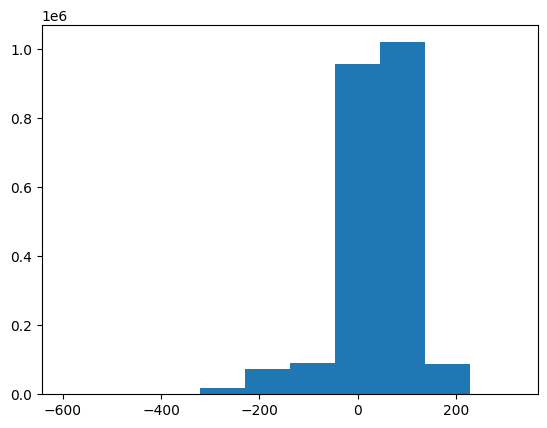

In [13]:
plt.hist(data['consumo'])

In [14]:
data['fecha'] = pd.to_datetime(data['fecha'])

C:\Users\troll\AppData\Local\Temp\ipykernel_17652\3211021378.py:1: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  data['fecha'] = pd.to_datetime(data['fecha'])


In [15]:
data[data['nombre'].str.startswith('BUIN')]

,id,fecha,consumo,calidad,muestras,nombre
1,395102211,2022-03-01 00:00:00-03:00,-168.352138,1,4,BUIN 110 HT1 MTP
2,395684211,2022-03-01 00:00:00-03:00,93.961443,1,4,BUIN 110 H2 P
8,393655211,2022-03-01 00:00:00-03:00,73.264123,1,4,BUIN 110 H1 P
16,854641211,2022-03-01 00:00:00-03:00,-0.113527,1,4,BUIN 110 H4 P
18,393572211,2022-03-01 00:00:00-03:00,-0.230716,1,4,BUIN 110 H3 P
...,...,...,...,...,...,...
2242929,393655211,2022-05-31 23:00:00-04:00,101.855672,1,4,BUIN 110 H1 P
2242930,395102211,2022-05-31 23:00:00-04:00,-235.736466,1,4,BUIN 110 HT1 MTP
2242931,395684211,2022-05-31 23:00:00-04:00,133.111552,1,4,BUIN 110 H2 P
2242944,393572211,2022-05-31 23:00:00-04:00,-0.230716,1,4,BUIN 110 H3 P


In [16]:
data_test = data.drop('id', axis=1)
data_test.head()

,fecha,consumo,calidad,muestras,nombre
0,2022-03-01 00:00:00-03:00,-8.458754,1,4,AJAHUEL 110 H1 P
1,2022-03-01 00:00:00-03:00,-168.352138,1,4,BUIN 110 HT1 MTP
2,2022-03-01 00:00:00-03:00,93.961443,1,4,BUIN 110 H2 P
3,2022-03-01 00:00:00-03:00,27.799431,1,4,LOSALME 110 H1 P
4,2022-03-01 00:00:00-03:00,55.301902,1,4,LOSALME 110 H3 P


Se debe reemplazar los nombres por comuna, asegurando  que se sume el consumo y se mantenga la fecha por hora, promediando las muestras y calidad

In [17]:
data_test['comuna'] = data['nombre'].str.split().str[0]


In [18]:
data_test['comuna'].value_counts()

comuna
CNAVIA     517608
FLORIDA    460096
BUIN       287560
CHENA      287560
AJAHUEL    230048
LOSALME    230048
ELSALTO    230048
Name: count, dtype: int64

<Axes: >

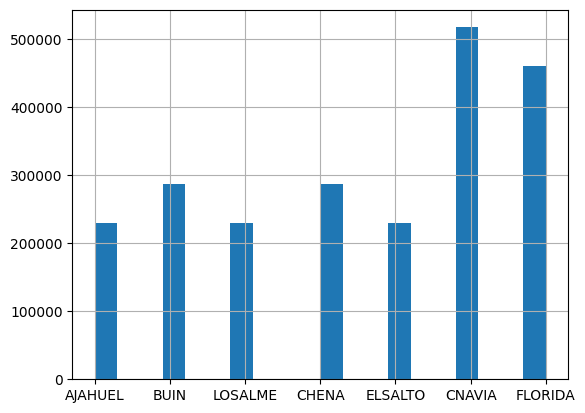

In [19]:
data_test['comuna'].hist(bins=20)

In [20]:
data_test['fecha'] = pd.to_datetime(data_test['fecha'],utc=True)
data_test['fecha'] =  data_test['fecha'].dt.tz_convert("America/Santiago")

In [21]:
data_test['hour'] = data_test['fecha'].dt.hour
data_test['day'] = data_test['fecha'].dt.day
data_test['month'] = data_test['fecha'].dt.month
data_test['year'] = data_test['fecha'].dt.year


In [22]:
data_agrupado = data_test.groupby(['comuna','fecha','day','month','hour','year']).agg({'muestras': 'mean', 'calidad': 'mean', 'consumo':'sum'}).reset_index()

In [23]:
data_agrupado

,comuna,fecha,day,month,hour,year,muestras,calidad,consumo
0,AJAHUEL,2017-02-28 15:00:00-03:00,28,2,15,2017,3.25,0.75,179.705306
1,AJAHUEL,2017-02-28 16:00:00-03:00,28,2,16,2017,4.00,1.00,184.789336
2,AJAHUEL,2017-02-28 17:00:00-03:00,28,2,17,2017,4.00,1.00,187.619336
3,AJAHUEL,2017-02-28 18:00:00-03:00,28,2,18,2017,4.00,1.00,182.389885
4,AJAHUEL,2017-02-28 19:00:00-03:00,28,2,19,2017,4.00,1.00,173.051792
...,...,...,...,...,...,...,...,...,...
387116,LOSALME,2023-06-27 19:00:00-04:00,27,6,19,2023,4.00,1.00,216.470914
387117,LOSALME,2023-06-27 20:00:00-04:00,27,6,20,2023,4.00,1.00,213.860067
387118,LOSALME,2023-06-27 21:00:00-04:00,27,6,21,2023,4.00,1.00,209.034960
387119,LOSALME,2023-06-27 22:00:00-04:00,27,6,22,2023,4.00,1.00,199.870564


In [24]:
train = data_agrupado.query("year > 2017 and year < 2022")

In [25]:
test = data_agrupado.query("year >= 2022")

In [26]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [27]:
comunas=["AJAHUEL","BUIN","CHENA","CNAVIA","ELSALTO","FLORIDA","LOSALME"]


<Axes: xlabel='hour', ylabel='consumo'>

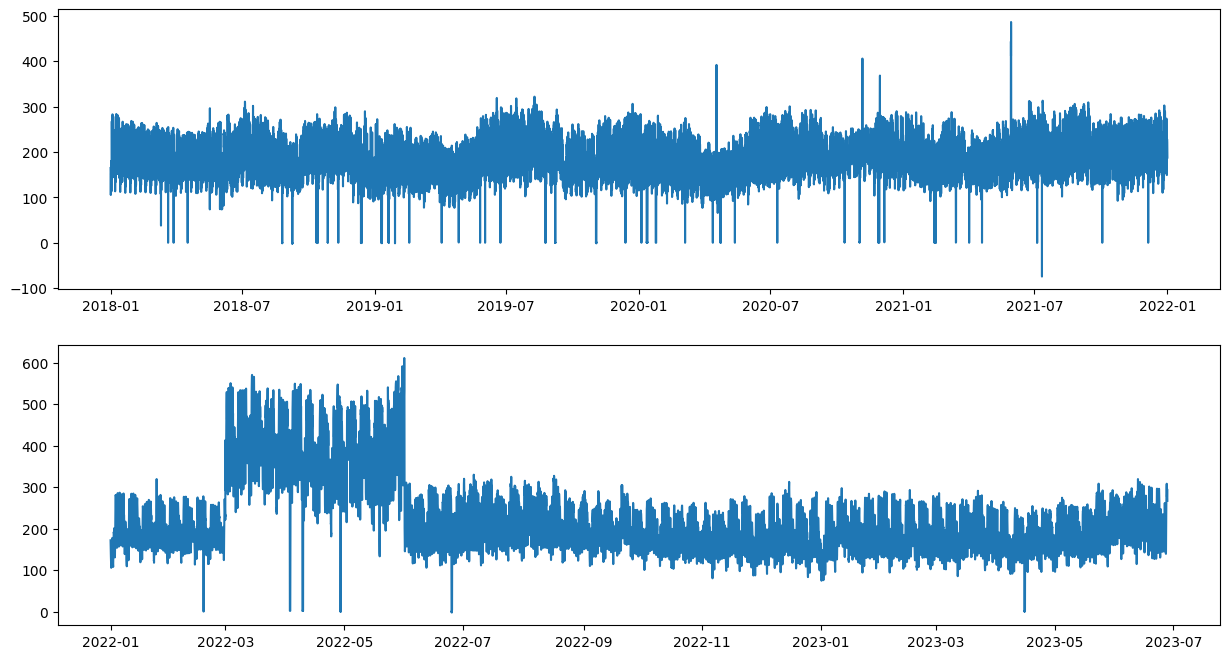

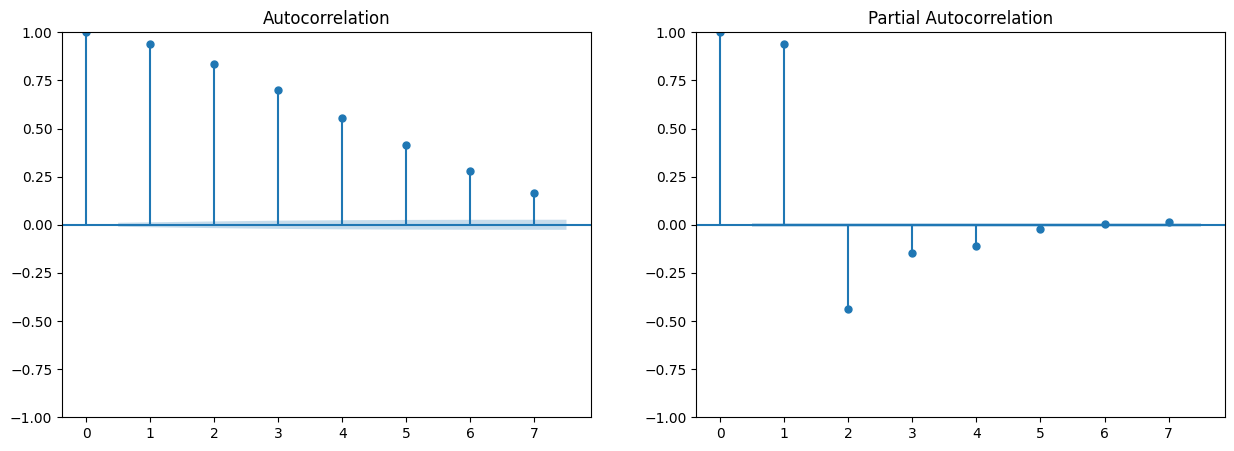

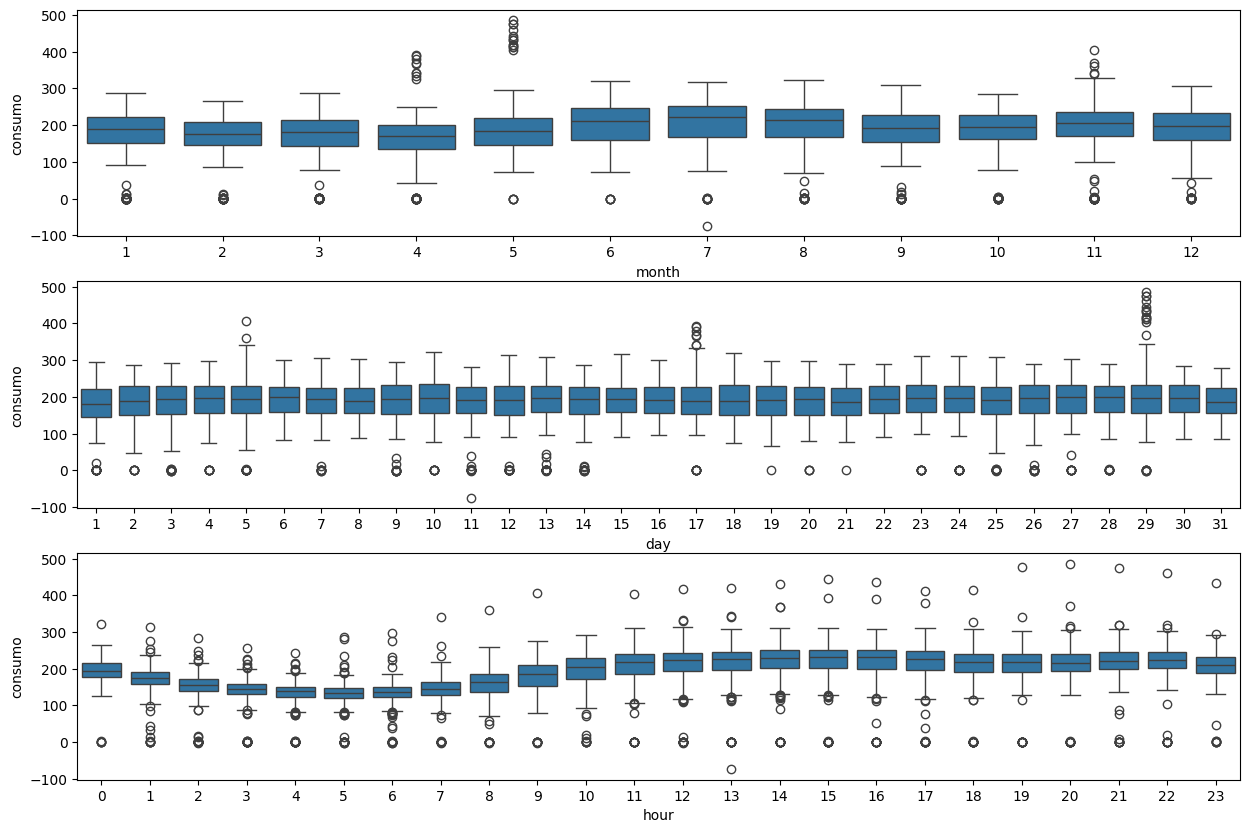

In [28]:
comuna="CHENA"
filtro="comuna=='{0}'".format(comuna)
y_c=train.query(filtro)["consumo"]
x_c=train.query(filtro)["fecha"]
yt_c=test.query(filtro)["consumo"]
xt_c=test.query(filtro)["fecha"]
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(x_c,y_c);
axes[1].plot(xt_c,yt_c);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(y_c,lags=7,ax=axes[0]);
plot_pacf(y_c,lags=7,method="ywm",ax=axes[1]);

dataf_c=pd.DataFrame()
dataf_c["consumo"]=y_c
dataf_c["date"]=x_c
dataf_c["day"]=dataf_c["date"].dt.day
dataf_c["hour"]=dataf_c["date"].dt.hour
dataf_c["month"]=dataf_c["date"].dt.month

fig, axes = plt.subplots(3,1)
fig.set_size_inches(15, 10)

sns.boxplot(x="month", y="consumo",data=dataf_c,ax=axes[0])
sns.boxplot(x="day", y="consumo",data=dataf_c,ax=axes[1])
sns.boxplot(x="hour", y="consumo",data=dataf_c,ax=axes[2])

<Axes: xlabel='hour', ylabel='consumo'>

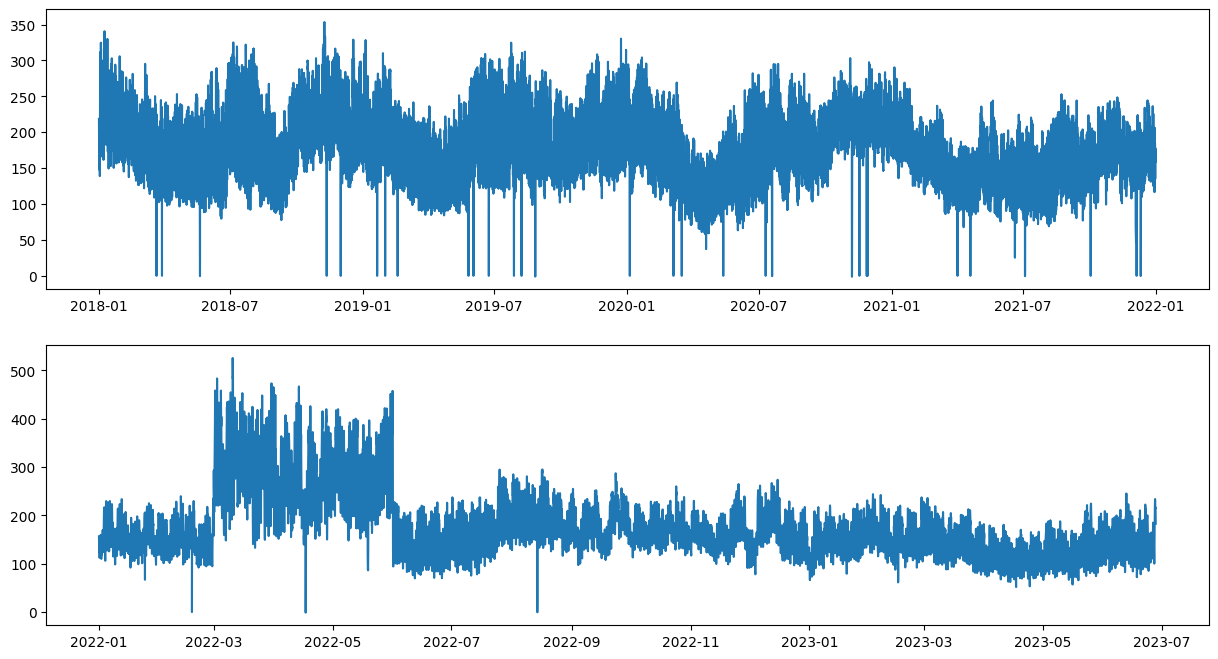

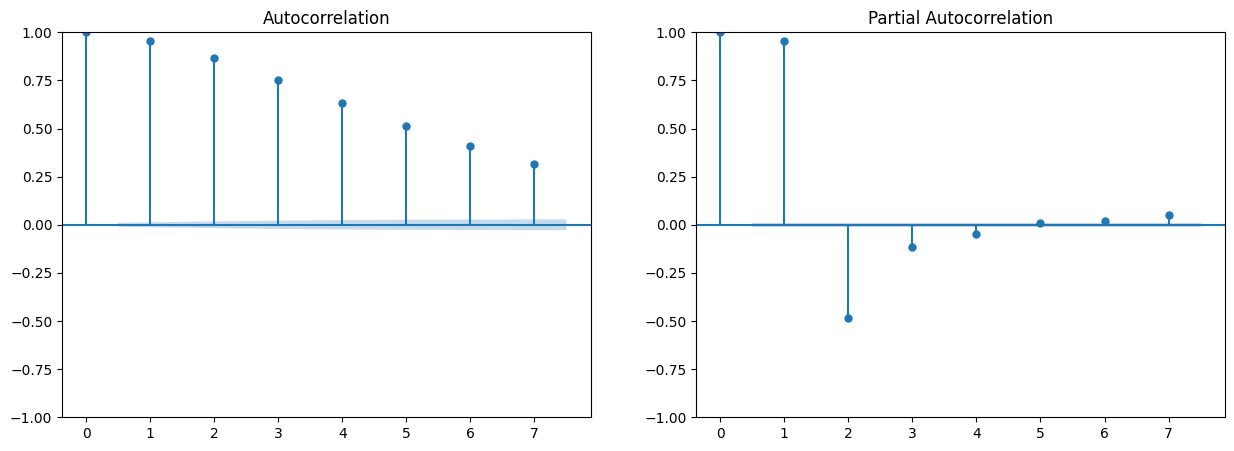

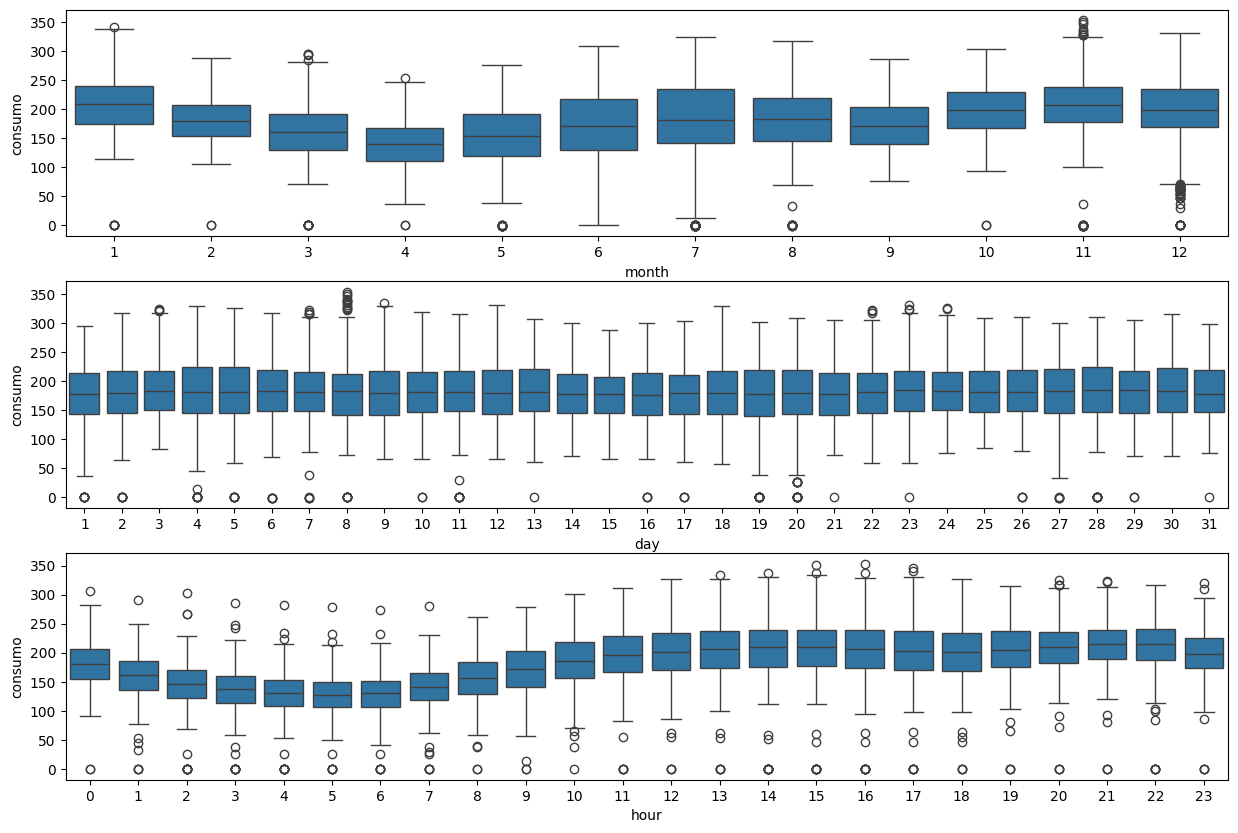

In [29]:
comuna="LOSALME"
filtro="comuna=='{0}'".format(comuna)
y_a=train.query(filtro)["consumo"]
x_a=train.query(filtro)["fecha"]
yt_a=test.query(filtro)["consumo"]
xt_a=test.query(filtro)["fecha"]
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(x_a,y_a);
axes[1].plot(xt_a,yt_a);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(y_a,lags=7,ax=axes[0]);
plot_pacf(y_a,lags=7,method="ywm",ax=axes[1]);

dataf_a=pd.DataFrame()
dataf_a["consumo"]=y_a
dataf_a["date"]=x_a
dataf_a["day"]=dataf_a["date"].dt.day
dataf_a["hour"]=dataf_a["date"].dt.hour
dataf_a["month"]=dataf_a["date"].dt.month

fig, axes = plt.subplots(3,1)
fig.set_size_inches(15, 10)

sns.boxplot(x="month", y="consumo",data=dataf_a,ax=axes[0])
sns.boxplot(x="day", y="consumo",data=dataf_a,ax=axes[1])
sns.boxplot(x="hour", y="consumo",data=dataf_a,ax=axes[2])

<Axes: xlabel='hour', ylabel='consumo'>

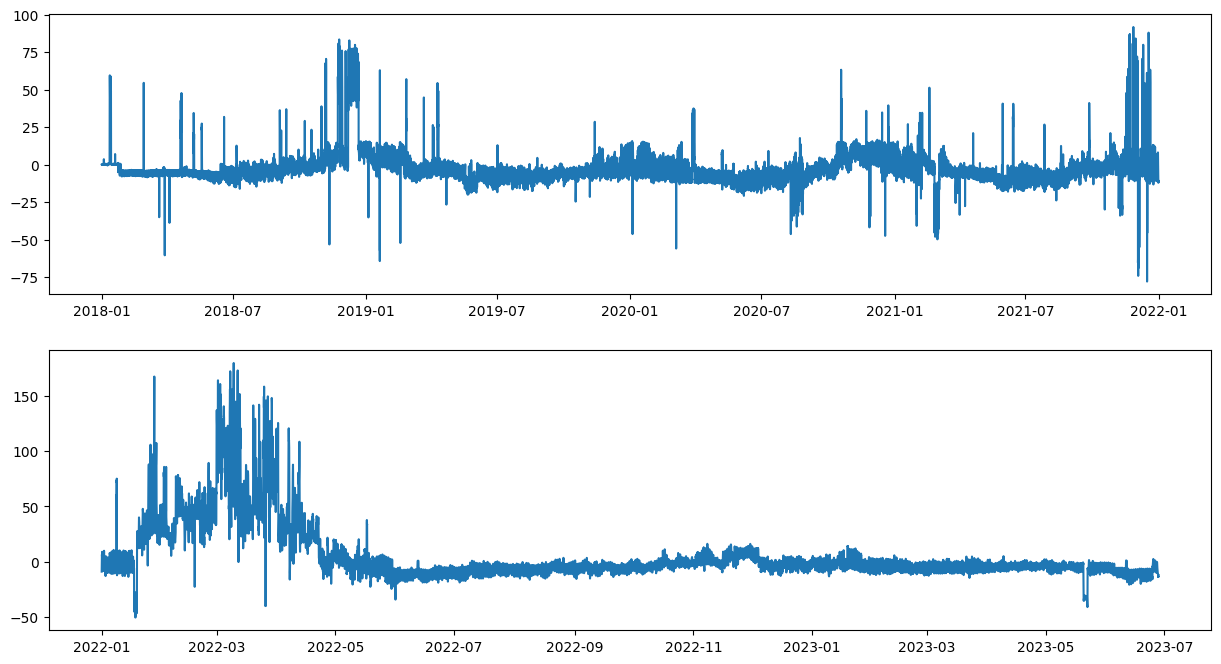

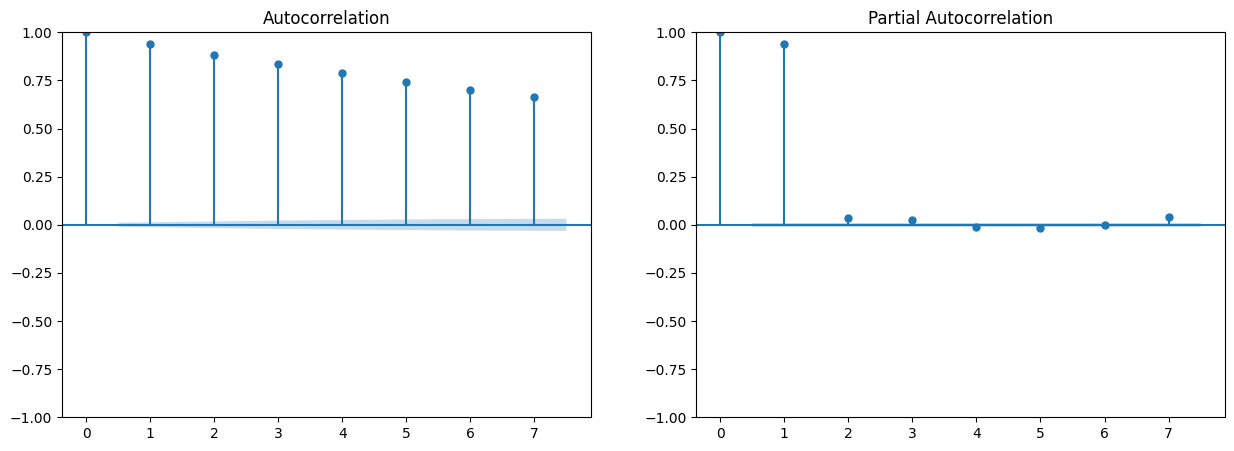

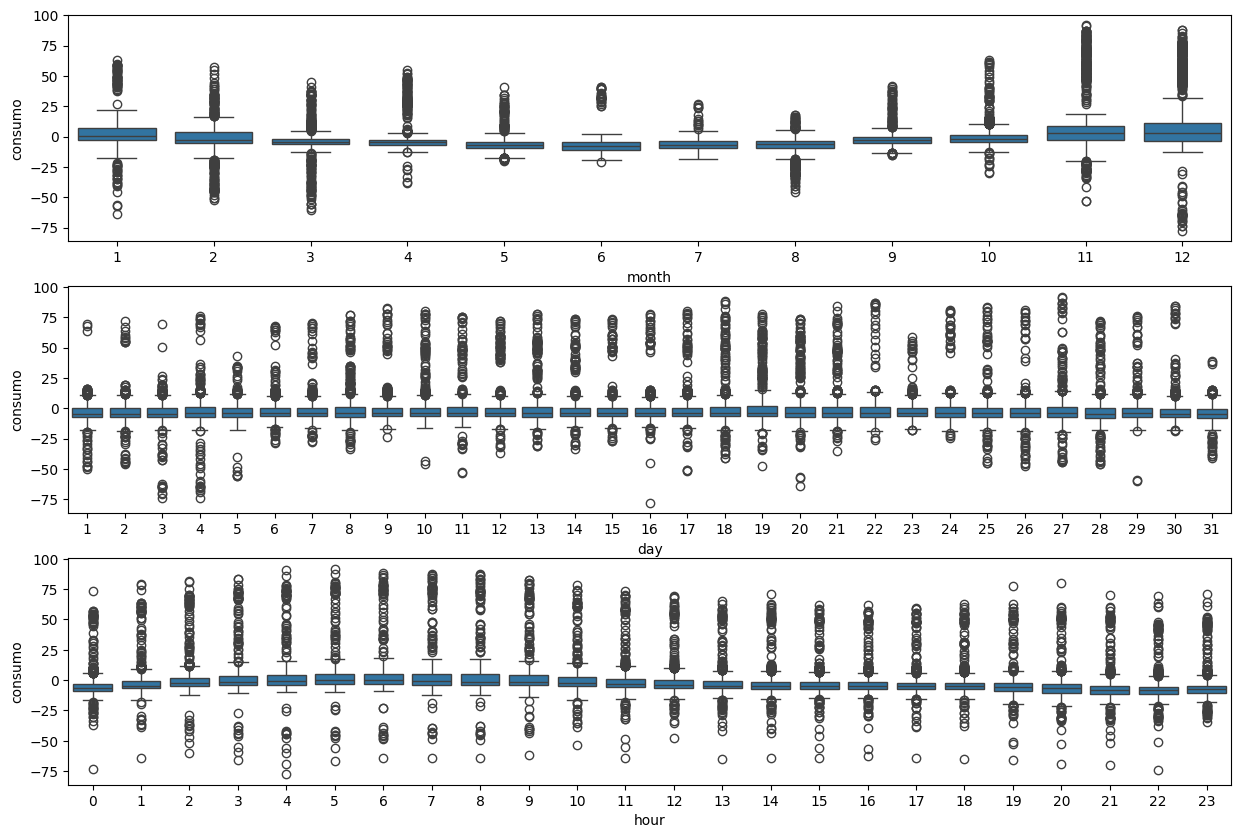

In [30]:
comuna="FLORIDA"
filtro="comuna=='{0}'".format(comuna)
y_f=train.query(filtro)["consumo"]
x_f=train.query(filtro)["fecha"]
yt_f=test.query(filtro)["consumo"]
xt_f=test.query(filtro)["fecha"]
fig, axes = plt.subplots(2,1)
fig.set_size_inches(15, 8)
axes[0].plot(x_f,y_f);
axes[1].plot(xt_f,yt_f);
fig, axes = plt.subplots(1,2)
fig.set_size_inches(15, 5)
plot_acf(y_f,lags=7,ax=axes[0]);
plot_pacf(y_f,lags=7,method="ywm",ax=axes[1]);

dataf_f=pd.DataFrame()
dataf_f["consumo"]=y_f
dataf_f["date"]=x_f
dataf_f["day"]=dataf_f["date"].dt.day
dataf_f["hour"]=dataf_f["date"].dt.hour
dataf_f["month"]=dataf_f["date"].dt.month

fig, axes = plt.subplots(3,1)
fig.set_size_inches(15, 10)

sns.boxplot(x="month", y="consumo",data=dataf_f,ax=axes[0])
sns.boxplot(x="day", y="consumo",data=dataf_f,ax=axes[1])
sns.boxplot(x="hour", y="consumo",data=dataf_f,ax=axes[2])

In [31]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_agrupado["consumo"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -8.566399
p-value: 0.000000
Critical Values:
	1%: -3.430
	5%: -2.862
	10%: -2.567


In [32]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error

In [33]:
#modelo arima consumo general
modelo_d=ARIMA(data_agrupado['consumo'],order=(8,0,8))
m_ad1=modelo_d.fit()
print("MSE",m_ad1.mse)
print("AIC",m_ad1.aic)
ysp=m_ad1.predict()
mape=mean_absolute_percentage_error(data_agrupado['consumo'],ysp)
print("MAPE",mape)

c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MSE 370.68998392008666
AIC 3388714.224705841
MAPE 596037535995325.8


Con estos resultados veremos si existe mejoria al remover las horas del dataset

In [34]:
dataf_a["year"]=dataf_a["date"].dt.year
dataf_c["year"]=dataf_c["date"].dt.year
dataf_f["year"]=dataf_f["date"].dt.year

In [35]:
dataf_a["date"]=pd.to_datetime(dataf_a["date"],format="%Y-%m-%d %H:%M:%S")
dataf_a=dataf_a.set_index("date")

dataf_c["date"]=pd.to_datetime(dataf_c["date"],format="%Y-%m-%d %H:%M:%S")
dataf_c=dataf_c.set_index("date")

dataf_f["date"]=pd.to_datetime(dataf_f["date"],format="%Y-%m-%d %H:%M:%S")
dataf_f=dataf_f.set_index("date")

In [36]:
dataf_a.head()

,consumo,day,hour,month,year
date,,,,,
2018-01-01 00:00:00-03:00,218.675048,1,0,1,2018
2018-01-01 01:00:00-03:00,202.256765,1,1,1,2018
2018-01-01 02:00:00-03:00,195.217009,1,2,1,2018
2018-01-01 03:00:00-03:00,181.340299,1,3,1,2018
2018-01-01 04:00:00-03:00,172.410573,1,4,1,2018


In [37]:
data_a_sh = dataf_a[['year','month','day','consumo']].groupby(['year','month','day']).agg("mean")
data_c_sh = dataf_c[['year','month','day','consumo']].groupby(['year','month','day']).agg("mean")
data_f_sh = dataf_f[['year','month','day','consumo']].groupby(['year','month','day']).agg("mean")

In [38]:
data_a_sh.head()

consumo
year month day            
2018 1     1    173.902118
           2    228.726666
           3    261.067647
           4    245.425994
           5    237.169533

In [39]:
#data_a_sh['fecha'] = pd.to_datetime(data_a_sh[['year','month','day']])
#data_a_sh.drop(['year','month','day'],axis=1,inplace=True)

#data_c_sh['fecha'] = pd.to_datetime(data_c_sh[['year','month','day']])
#data_c_sh.drop(['year','month','day'],axis=1,inplace=True)

#data_f_sh['fecha'] = pd.to_datetime(data_f_sh[['year','month','day']])
#data_f_sh.drop(['year','month','day'],axis=1,inplace=True)

In [40]:
date_index = pd.to_datetime([f"{year}-{month}-{day}" for year, month, day in data_a_sh.index])
data_a_sh.index = date_index


In [41]:
data_a_sh.index.name = 'fecha'

In [42]:
date_index = pd.to_datetime([f"{year}-{month}-{day}" for year, month, day in data_c_sh.index])
data_c_sh.index = date_index
data_c_sh.index.name = 'fecha'
date_index = pd.to_datetime([f"{year}-{month}-{day}" for year, month, day in data_f_sh.index])
data_f_sh.index = date_index
data_f_sh.index.name = 'fecha'

In [43]:
#losalme
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_a_sh['consumo'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.419160
p-value: 0.010323
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [44]:
#chena
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_c_sh['consumo'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.949108
p-value: 0.001702
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [45]:
#florida
from statsmodels.tsa.stattools import adfuller
result = adfuller(data_f_sh['consumo'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -3.756073
p-value: 0.003390
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


In [46]:
#modelo arima losalme
modelo_a=ARIMA(data_a_sh['consumo'],order=(8,0,8))
m_ad1_a=modelo_a.fit()
print("MSE",m_ad1_a.mse)
print("AIC",m_ad1_a.aic)
ysp_a=m_ad1_a.predict()
mape_a=mean_absolute_percentage_error(data_a_sh['consumo'],ysp_a)
print("MAPE",mape_a)

c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MSE 204.10561447011597
AIC 11945.471709747077
MAPE 0.06151579502454182


c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [47]:
modelo_c=ARIMA(data_c_sh['consumo'],order=(8,0,8))
m_ad1_c=modelo_c.fit()
print("MSE",m_ad1_c.mse)
print("AIC",m_ad1_c.aic)
ysp_c=m_ad1_c.predict()
mape_c=mean_absolute_percentage_error(data_c_sh['consumo'],ysp_c)
print("MAPE",mape_c)

c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MSE 292.5738467885296
AIC 12477.894885209538
MAPE 0.0784047957394523


c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [48]:
modelo_f=ARIMA(data_f_sh['consumo'],order=(8,0,8))
m_ad1_f=modelo_f.fit()
print("MSE",m_ad1_f.mse)
print("AIC",m_ad1_f.aic)
ysp_f=m_ad1_f.predict()
mape_f=mean_absolute_percentage_error(data_f_sh['consumo'],ysp_f)
print("MAPE",mape_f)

c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MSE 27.5977619858922
AIC 9027.595539825696
MAPE 1.6217231031053423


c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


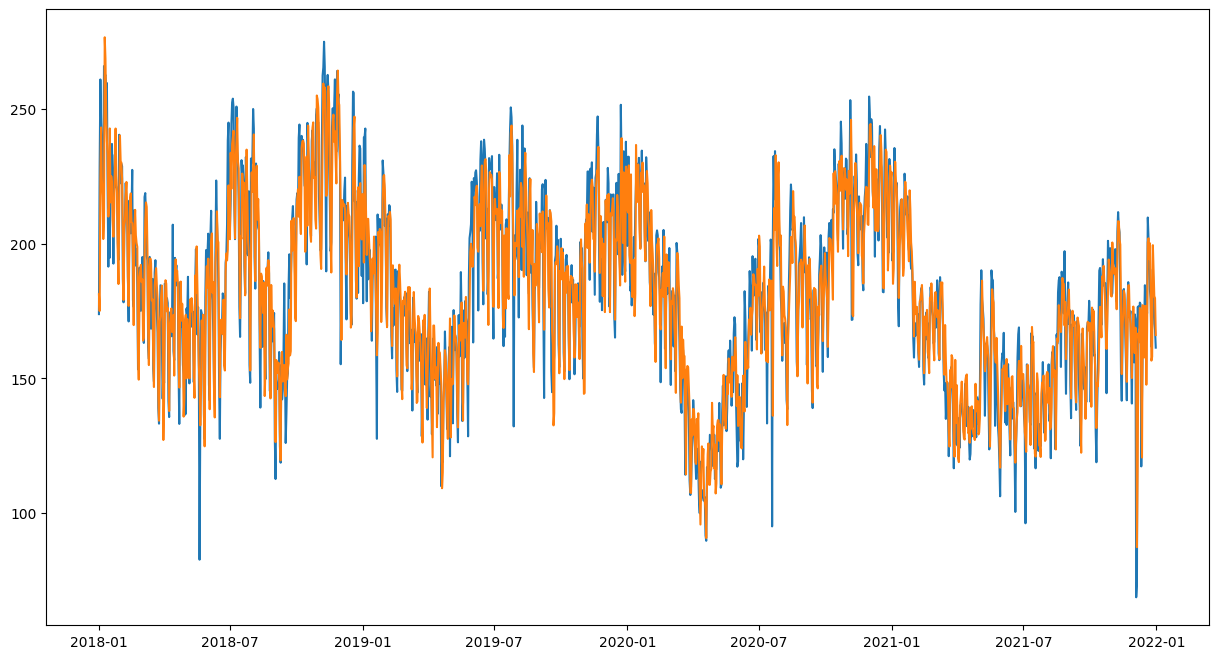

In [49]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(data_a_sh.index,data_a_sh['consumo'],data_a_sh.index,ysp_a);



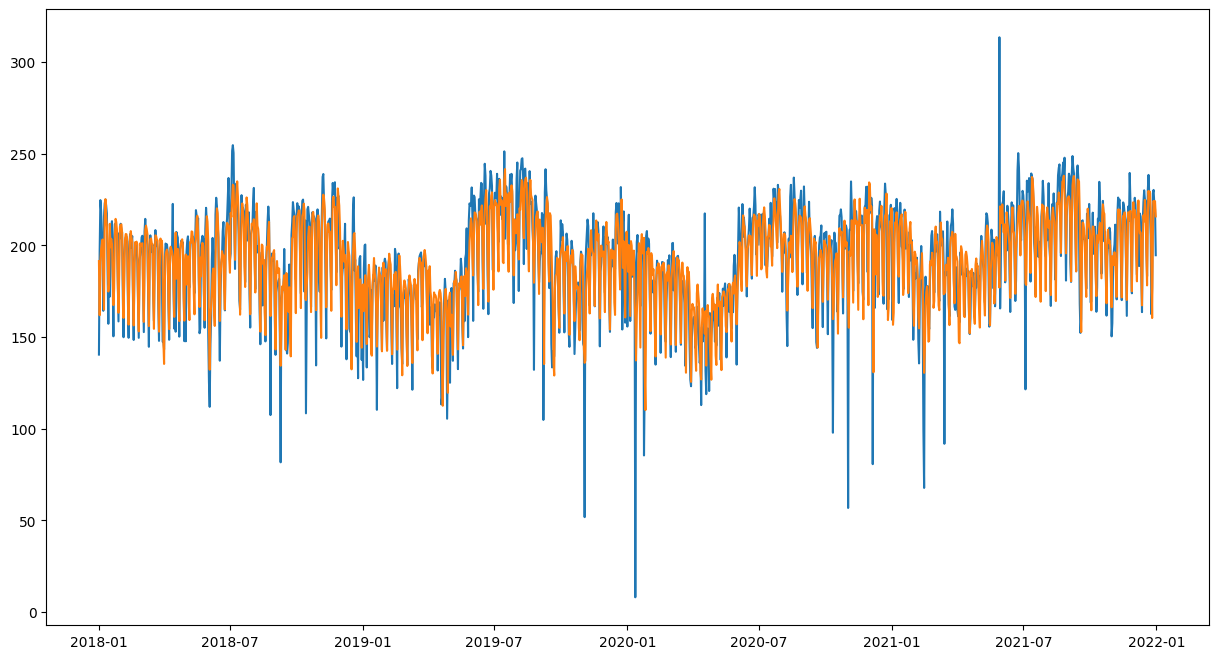

In [50]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(data_c_sh.index,data_c_sh['consumo'],data_c_sh.index,ysp_c);

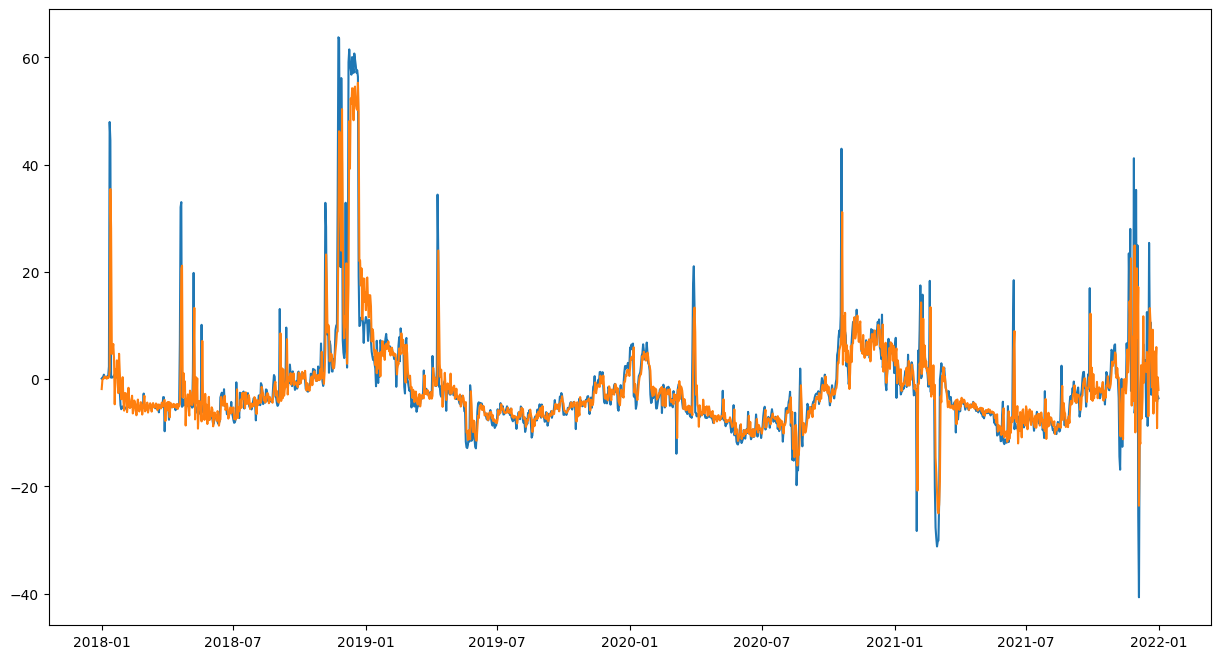

In [51]:
fig, axes = plt.subplots(1,1)
fig.set_size_inches(15, 8)
axes.plot(data_f_sh.index,data_f_sh['consumo'],data_f_sh.index,ysp_f);

Con esto podremos observar tendencias del consumo

In [52]:
from sklearn.model_selection import train_test_split
#X = data_agrupado.drop(['consumo'], axis=1)

#y = data_agrupado['consumo']

In [53]:
X_train = train.drop(["consumo"], axis=1)
X_test = test.drop(["consumo"], axis=1)
y_train = train["consumo"]
y_test = test["consumo"]

In [54]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 91231 entries, 42270 to 387120
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype                           
---  ------    --------------  -----                           
 0   comuna    91231 non-null  object                          
 1   fecha     91231 non-null  datetime64[ns, America/Santiago]
 2   day       91231 non-null  int32                           
 3   month     91231 non-null  int32                           
 4   hour      91231 non-null  int32                           
 5   year      91231 non-null  int32                           
 6   muestras  91231 non-null  float64                         
 7   calidad   91231 non-null  float64                         
dtypes: datetime64[ns, America/Santiago](1), float64(2), int32(4), object(1)
memory usage: 4.9+ MB


In [55]:
train_data =  X_train.join(y_train)

In [56]:
train_data  = train_data.join(pd.get_dummies(train_data.comuna)).drop(['comuna'],axis=1)

In [57]:
train_data 

,fecha,day,month,hour,year,muestras,calidad,consumo,AJAHUEL,BUIN,CHENA,CNAVIA,ELSALTO,FLORIDA,LOSALME
7353,2018-01-01 00:00:00-03:00,1,1,0,2018,4.0,1.0,137.330840,True,False,False,False,False,False,False
7354,2018-01-01 01:00:00-03:00,1,1,1,2018,4.0,1.0,124.045549,True,False,False,False,False,False,False
7355,2018-01-01 02:00:00-03:00,1,1,2,2018,4.0,1.0,118.137811,True,False,False,False,False,False,False
7356,2018-01-01 03:00:00-03:00,1,1,3,2018,4.0,1.0,107.899499,True,False,False,False,False,False,False
7357,2018-01-01 04:00:00-03:00,1,1,4,2018,4.0,1.0,100.362069,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
374083,2021-12-31 19:00:00-03:00,31,12,19,2021,4.0,1.0,168.644175,False,False,False,False,False,False,True
374084,2021-12-31 20:00:00-03:00,31,12,20,2021,4.0,1.0,171.593959,False,False,False,False,False,False,True
374085,2021-12-31 21:00:00-03:00,31,12,21,2021,4.0,1.0,160.167061,False,False,False,False,False,False,True
374086,2021-12-31 22:00:00-03:00,31,12,22,2021,4.0,1.0,169.694060,False,False,False,False,False,False,True


In [58]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 244419 entries, 7353 to 374087
Data columns (total 15 columns):
 #   Column    Non-Null Count   Dtype                           
---  ------    --------------   -----                           
 0   fecha     244419 non-null  datetime64[ns, America/Santiago]
 1   day       244419 non-null  int32                           
 2   month     244419 non-null  int32                           
 3   hour      244419 non-null  int32                           
 4   year      244419 non-null  int32                           
 5   muestras  244419 non-null  float64                         
 6   calidad   244419 non-null  float64                         
 7   consumo   244419 non-null  float64                         
 8   AJAHUEL   244419 non-null  bool                            
 9   BUIN      244419 non-null  bool                            
 10  CHENA     244419 non-null  bool                            
 11  CNAVIA    244419 non-null  bool          

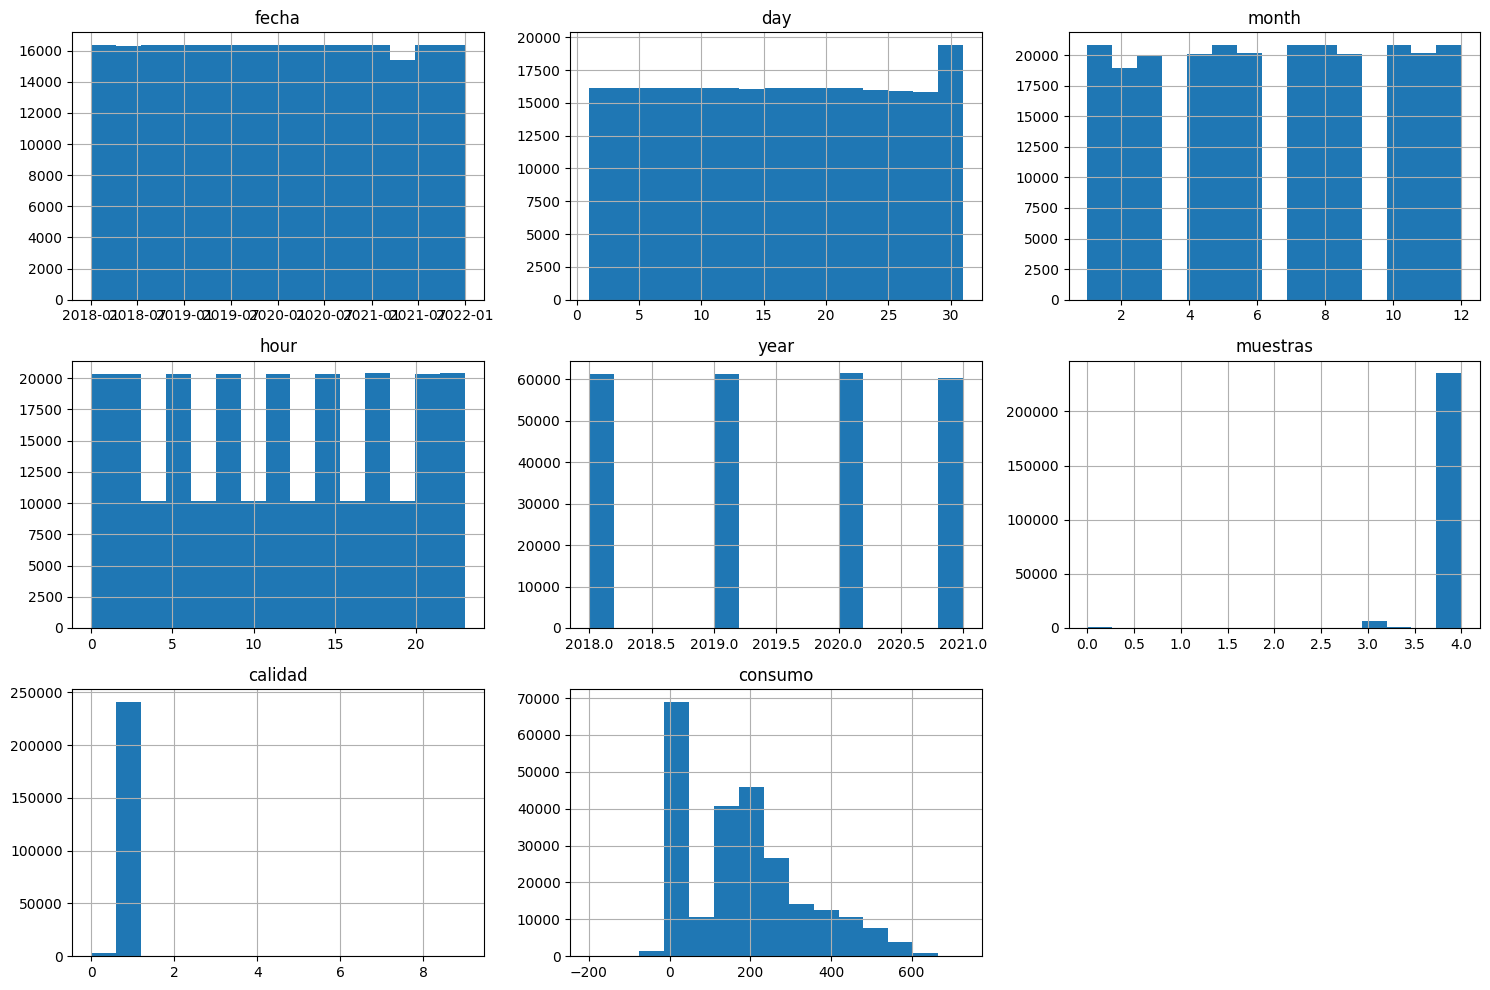

In [59]:
train_data.hist(figsize=(15,10),bins=15)
plt.tight_layout()

In [60]:
train_data.value_counts('consumo')

consumo
0.000000      478
101.435617     24
195.981968     19
140.971124     19
118.883963     14
             ... 
116.813311      1
116.816633      1
116.822439      1
116.824636      1
727.554969      1
Name: count, Length: 241940, dtype: int64

<Axes: >

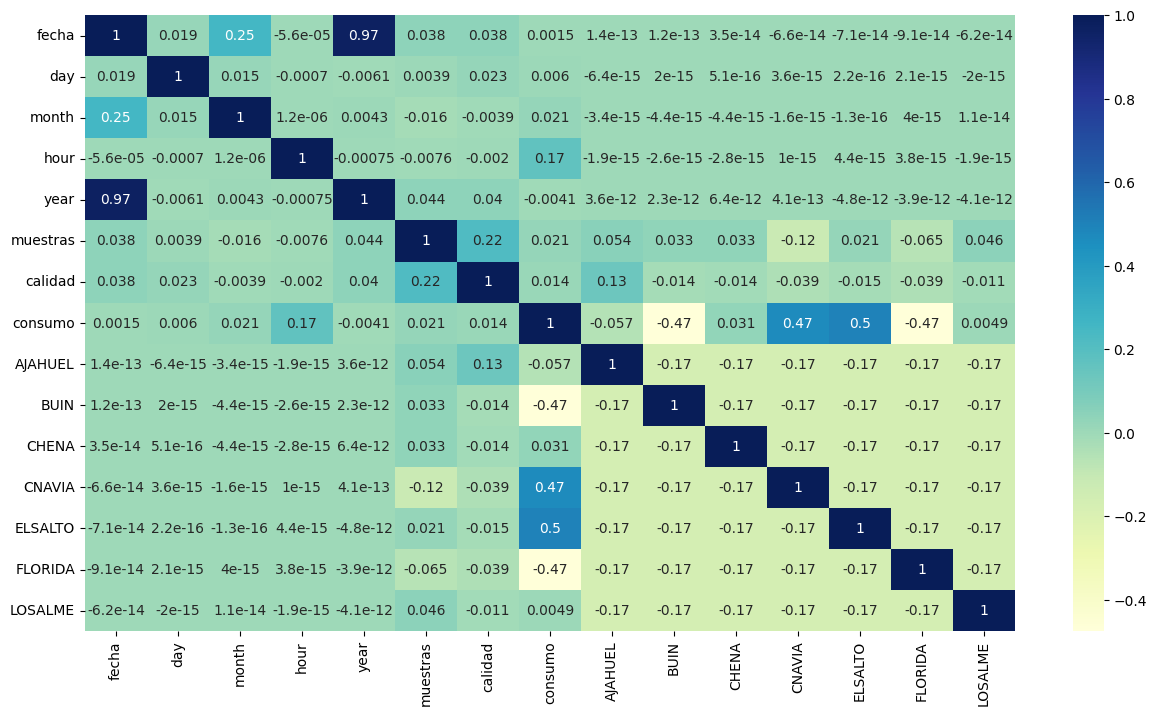

In [61]:
plt.figure(figsize=(15,8))
sns.heatmap(train_data.corr(),annot=True,cmap="YlGnBu")

<Axes: title={'center': 'Consumo en El Salto'}>

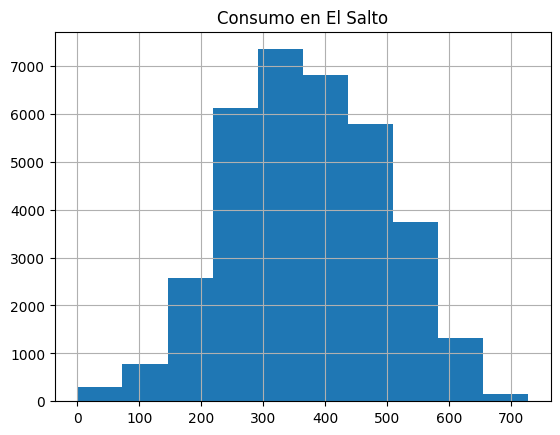

In [62]:
plt.title('Consumo en El Salto')
train_data['consumo'].where(train_data['ELSALTO']==True).hist()

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train, y_train = train_data.drop(['consumo', 'fecha'], axis=1), train_data['consumo']
X_train_s  = scaler.fit_transform(X_train)
reg = LinearRegression()
reg.fit(X_train, y_train)

LinearRegression()

In [64]:
test_data =  X_test.join(y_test)
test_data  = test_data.join(pd.get_dummies(test_data.comuna)).drop(['comuna'],axis=1)
#test_data['fecha'] = pd.to_datetime(test_data['fecha'],utc=True)
#test_data['fecha'] =  train_data['fecha'].dt.tz_convert("America/Santiago")
#test_data['hora'] = test_data['fecha'].dt.hour
#test_data['dia'] = train_data['fecha'].dt.day
#test_data['mes'] = train_data['fecha'].dt.month

In [65]:
X_test, y_test = test_data.drop(['consumo','fecha'],  axis=1), test_data['consumo']
X_test_s = scaler.transform(X_test)

In [66]:
reg_score = reg.score(X_test,y_test)
reg_score

0.5984763686440866

Usando Random Forest

In [67]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()
forest.fit(X_train_s, y_train)

RandomForestRegressor()

In [68]:
forest_score = forest.score(X_test_s, y_test)
forest_score

0.6383164720018797

Usando Support Vector Regression

In [69]:
from sklearn.svm import LinearSVR 

svr = LinearSVR()
svr.fit(X_train_s, y_train)

c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVR()

In [70]:
svr_score = svr.score(X_test_s, y_test)
svr_score

0.5833233983296029

Usando Decision Tree

In [71]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor()

In [72]:
tree_score = tree.score(X_test, y_test)
tree_score

0.6344172149814521

Utilizando MLP

In [73]:
from mlp import PerceptronMulticapaK


In [74]:
X_train_mlp = np.asarray(X_train).astype('float32')
y_train_mlp = np.asarray(y_train).astype('float32')
X_test_mlp = np.asarray(X_test).astype('float32')
y_test_mlp = np.asarray(y_test).astype('float32')
mlp = PerceptronMulticapaK(X_train_mlp)
mlp.train(X_train_mlp,y_train_mlp,X_test_mlp,y_test_mlp)

c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\preprocessing\normalization.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/128
7639/7639 ━━━━━━━━━━━━━━━━━━━━ 12s 1ms/step - RootMeanSquaredError: 75.0644 - loss: 5907.7876 - val_RootMeanSquaredError: 136.2192 - val_loss: 18555.6680
Epoch 2/128
7639/7639 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - RootMeanSquaredError: 66.4678 - loss: 4418.0898 - val_RootMeanSquaredError: 141.6258 - val_loss: 20057.8633
Epoch 3/128
7639/7639 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - RootMeanSquaredError: 66.2822 - loss: 4393.4707 - val_RootMeanSquaredError: 139.3796 - val_loss: 19426.6738
Epoch 4/128
7639/7639 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - RootMeanSquaredError: 66.1926 - loss: 4381.5972 - val_RootMeanSquaredError: 138.1343 - val_loss: 19081.0742
Epoch 5/128
7639/7639 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - RootMeanSquaredError: 66.1434 - loss: 4375.2476 - val_RootMeanSquaredError: 136.9945 - val_loss: 18767.4980
Epoch 6/128
7639/7639 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step - RootMeanSquaredError: 66.2591 - loss: 4390.4116 - val_RootMeanSquaredError: 134.7822 - val_loss: 18166.2539
Epoc

In [75]:
mse_test, rmse_test = mlp.model.evaluate(X_test_mlp,y_test_mlp)
mse_test, rmse_test

2851/2851 ━━━━━━━━━━━━━━━━━━━━ 2s 632us/step - RootMeanSquaredError: 117.2598 - loss: 14868.1406


(18611.0234375, 136.42222595214844)

In [76]:
from sklearn.metrics import mean_squared_error

y_pred_reg = reg.predict(X_test)
y_pred_forest = forest.predict(X_test)
y_pred_svr = svr.predict(X_test)
y_pred_tree = tree.predict(X_test)
rmse_reg = np.sqrt(mean_squared_error(y_test,y_pred_reg))
rmse_forest = np.sqrt(mean_squared_error(y_test,y_pred_forest))
rmse_svr = np.sqrt(mean_squared_error(y_test,y_pred_svr))
rmse_tree = np.sqrt(mean_squared_error(y_test,y_pred_tree))


rmse_models = {"Linear": rmse_reg, "Random Forest": rmse_forest, "SVR": rmse_svr, "Decision Tree": rmse_tree, "MLP": rmse_test}
print(f"RMSE Reg {rmse_reg}, RMSE forest {rmse_forest}, RMSE svr {rmse_svr}, RMSE Tree {rmse_tree}, RMSE mlp {rmse_test}")


c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


RMSE Reg 136.21544336621156, RMSE forest 217.8978942096213, RMSE svr 2544.63615535688, RMSE Tree 129.9761478846938, RMSE mlp 136.42222595214844


c:\Users\troll\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LinearSVR was fitted without feature names
  warnings.warn(


In [77]:
y_pred_mlp = pd.read_csv("yv_pred.csv",sep=',')
y_pred_mlp.rename(columns={list(y_pred_mlp)[0]: 'consumo'}, inplace=True)

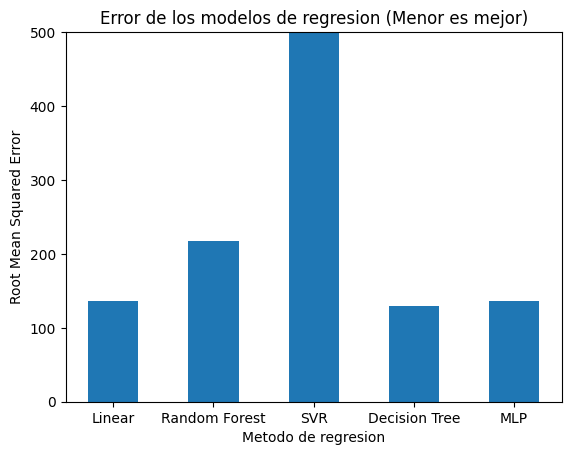

In [78]:
plt.bar(rmse_models.keys(), rmse_models.values(), width=0.5)
plt.ylim(0,500)
plt.xlabel("Metodo de regresion")
plt.ylabel("Root Mean Squared Error")
plt.title("Error de los modelos de regresion (Menor es mejor)")
plt.show()

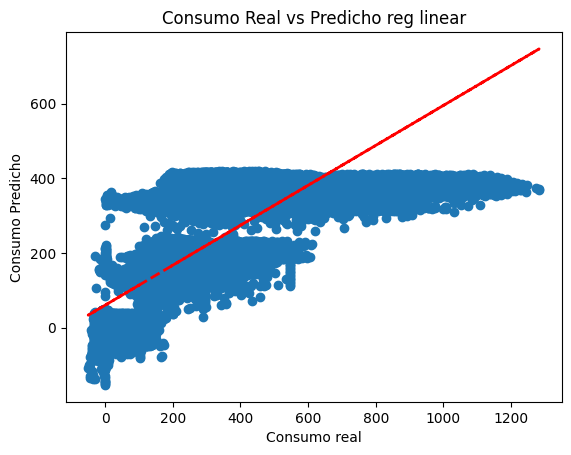

In [79]:
a,b = np.polyfit(y_test, y_pred_reg,1)
plt.plot(y_test, a*y_test+b, color='red',linestyle='--', linewidth=2)
plt.scatter(y_test, y_pred_reg)
plt.xlabel('Consumo real')
plt.ylabel('Consumo Predicho')
plt.title('Consumo Real vs Predicho reg linear')
plt.show()


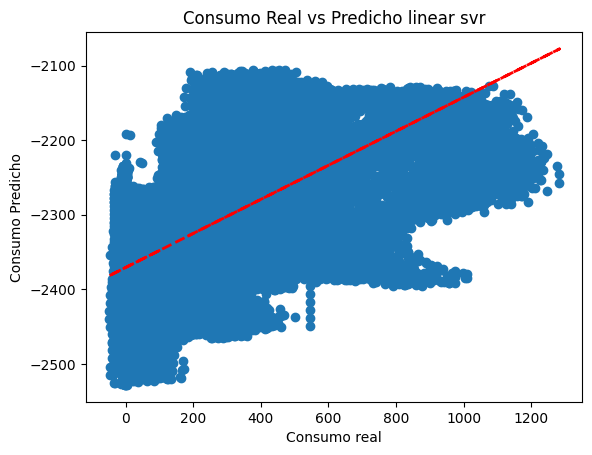

In [80]:
a,b = np.polyfit(y_test, y_pred_svr,1)
plt.plot(y_test, a*y_test+b, color='red',linestyle='--', linewidth=2)
plt.scatter(y_test, y_pred_svr)
plt.xlabel('Consumo real')
plt.ylabel('Consumo Predicho')
plt.title('Consumo Real vs Predicho linear svr')
plt.show()


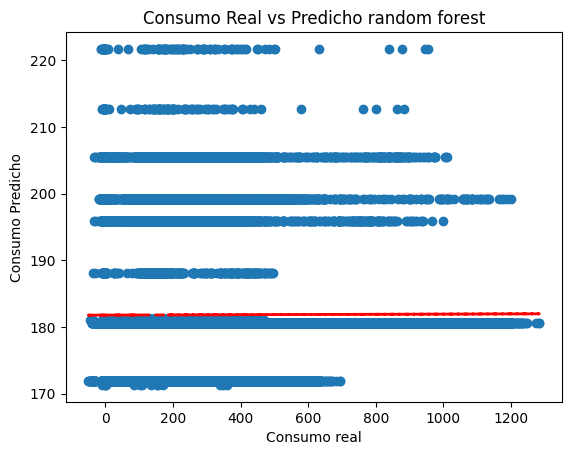

In [81]:
a,b = np.polyfit(y_test, y_pred_forest,1)
plt.plot(y_test, a*y_test+b, color='red',linestyle='--', linewidth=2)
plt.scatter(y_test, y_pred_forest)
plt.xlabel('Consumo real')
plt.ylabel('Consumo Predicho')
plt.title('Consumo Real vs Predicho random forest')
plt.show()

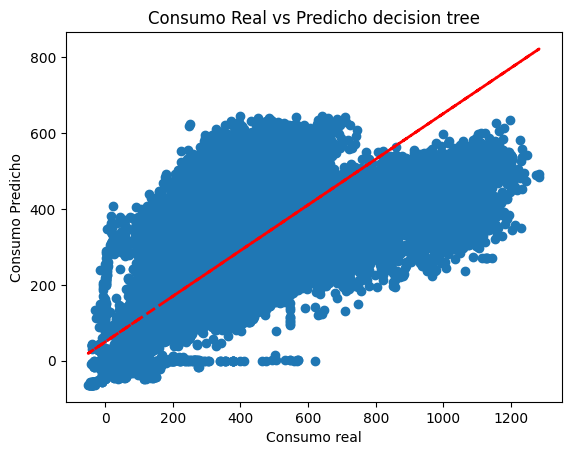

In [82]:
a,b = np.polyfit(y_test, y_pred_tree,1)
plt.plot(y_test, a*y_test+b, color='red',linestyle='--', linewidth=2)
plt.scatter(y_test, y_pred_tree)
plt.xlabel('Consumo real')
plt.ylabel('Consumo Predicho')
plt.title('Consumo Real vs Predicho decision tree')
plt.show()

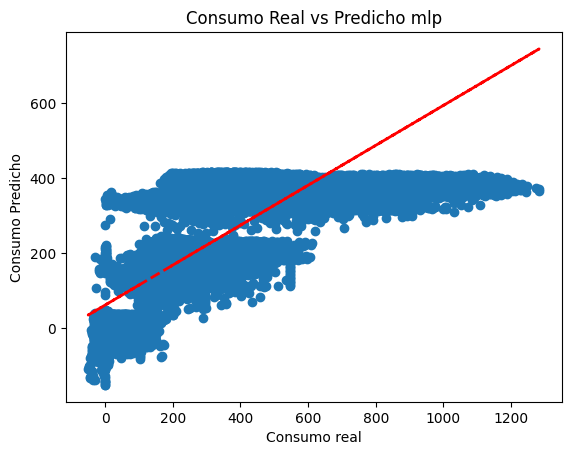

In [83]:
a,b = np.polyfit(y_test, y_pred_mlp,1)
plt.plot(y_test, a*y_test+b, color='red',linestyle='--', linewidth=2)
plt.scatter(y_test, y_pred_mlp)
plt.xlabel('Consumo real')
plt.ylabel('Consumo Predicho')
plt.title('Consumo Real vs Predicho mlp')
plt.show()

Entrenar modelos para Losalme, florida, chena

Predecir para 7 dias

In [84]:
yw_a=[]
yt_a=[]
window=7
for i in range(0,len(data_a_sh['consumo'])):
    if i+window < len(data_a_sh['consumo']):
        row=[]
        for j in range(window):
            row.append(data_a_sh['consumo'][i+j])
        yw_a.append(row)
        yt_a.append(data_a_sh['consumo'][i+window])
    else:
        break
print(len(yw_a))

1454


C:\Users\troll\AppData\Local\Temp\ipykernel_17652\3730100851.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row.append(data_a_sh['consumo'][i+j])
C:\Users\troll\AppData\Local\Temp\ipykernel_17652\3730100851.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yt_a.append(data_a_sh['consumo'][i+window])


In [85]:
yw_c=[]
yt_c=[]
window=7
for i in range(0,len(data_c_sh['consumo'])):
    if i+window < len(data_c_sh['consumo']):
        row=[]
        for j in range(window):
            row.append(data_c_sh['consumo'][i+j])
        yw_c.append(row)
        yt_c.append(data_c_sh['consumo'][i+window])
    else:
        break
print(len(yw_c))

1454


C:\Users\troll\AppData\Local\Temp\ipykernel_17652\160895639.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row.append(data_c_sh['consumo'][i+j])
C:\Users\troll\AppData\Local\Temp\ipykernel_17652\160895639.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yt_c.append(data_c_sh['consumo'][i+window])


In [86]:
yw_f=[]
yt_f=[]
window=7
for i in range(0,len(data_f_sh['consumo'])):
    if i+window < len(data_f_sh['consumo']):
        row=[]
        for j in range(window):
            row.append(data_f_sh['consumo'][i+j])
        yw_f.append(row)
        yt_f.append(data_f_sh['consumo'][i+window])
    else:
        break
print(len(yw_f))

1454


C:\Users\troll\AppData\Local\Temp\ipykernel_17652\1836449125.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row.append(data_f_sh['consumo'][i+j])
C:\Users\troll\AppData\Local\Temp\ipykernel_17652\1836449125.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yt_f.append(data_f_sh['consumo'][i+window])


In [87]:
yw_a=np.asarray(yw_a)
yt_a=np.asarray(yt_a)
yw_c=np.asarray(yw_c)
yt_c=np.asarray(yt_c)
yw_f=np.asarray(yw_f)
yt_f=np.asarray(yt_f)

In [90]:
seed=42069
rd.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [107]:
from datetime import datetime
now = datetime.now()

In [128]:
d=256
input=Input(name="activity",shape=(7,1))
q = Dense(name="wq",units=d)(input)
k = Dense(name="wk",units=d)(input)
v = Dense(name="wv",units=d)(input)
attention = Attention()([q, v, k],return_attention_scores=True)
hidden=Dense(d, activation='linear')(attention)
flatten=Flatten()(hidden)
output=Dense(1, activation='linear')(flatten)
model=Model(inputs=input,outputs=output)
model.summary()

Model: "functional_15"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ activity            │ (None, 7, 1)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wq (Dense)          │ (None, 7, 256)    │        512 │ activity[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wv (Dense)          │ (None, 7, 256)    │        512 │ activity[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ wk (Dense)          │ (None, 7, 256)    │        512 │ activity[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_3         │ (None, 7, 256)    │          0 │ wq[0][0],         │
│ (Attention)         │                   │            │ wv[0][0],         │
│                     │                   │            │ wk[0][0]          │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 7, 256)    │     65,792 │ attention_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 1792)      │          0 │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │      1,793 │ flatten_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 69,121 (270.00 KB)

 Trainable params: 69,121 (270.00 KB)

 Non-trainable params: 0 (0.00 B)

In [129]:
tag_a="model_a"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag_a
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-3)

model.compile(optimizer="Adam", loss='mse', metrics=['mse','mae','mape'])
rnn_a = model.fit(yw_a, yt_a, batch_size=128, epochs=128,verbose=1,callbacks=[tensorboard_callback])
model.save(log_dir+'/model_{0}.keras'.format(tag_a))

Epoch 1/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 8169.9458 - mae: 75.8476 - mape: 42.2192 - mse: 8169.9458 
Epoch 2/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1152.1866 - mae: 27.5423 - mape: 15.6487 - mse: 1152.1866
Epoch 3/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 854.5319 - mae: 23.9768 - mape: 13.0740 - mse: 854.5319 
Epoch 4/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 450.2484 - mae: 17.0177 - mape: 9.8252 - mse: 450.2484
Epoch 5/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 445.6641 - mae: 16.3426 - mape: 9.6621 - mse: 445.6641
Epoch 6/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 438.7130 - mae: 16.5816 - mape: 9.6467 - mse: 438.7130
Epoch 7/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 439.1497 - mae: 16.7423 - mape: 9.6638 - mse: 439.1497
Epoch 8/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 434.9209 - mae: 16.6674 - mape: 9.6279 - mse: 434.9209
Epoch 9/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 433.4519 - 

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


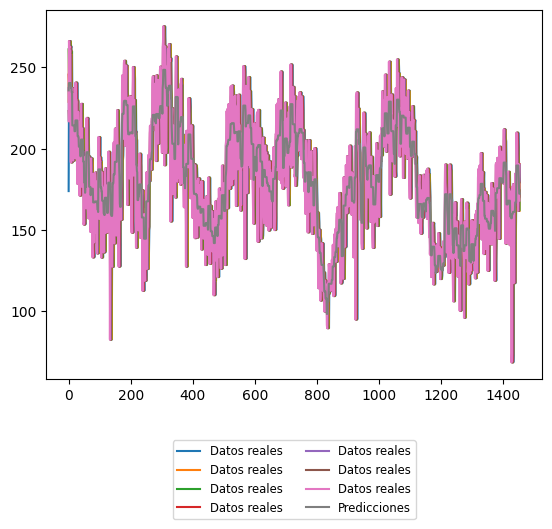

In [133]:
xw_a=[i for i in range(len(yw_a))]
yp_a=model.predict(yw_a)
plt.plot(xw_a, yw_a, label='Datos reales')
plt.plot(xw_a, yp_a, label='Predicciones')

plt.legend(fontsize='small', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)

plt.show()

In [130]:
attention_output_a,attention_scores_a=model.layers[4]([yw_a[:1].reshape(1,7,1),
                yw_a[:1].reshape(1,7,1),
                yw_a[:1].reshape(1,7,1)],
                return_attention_scores=True)

In [131]:
timesteps = ["t"+str(i) for i in range(8)]
timesteps.reverse()

<Axes: >

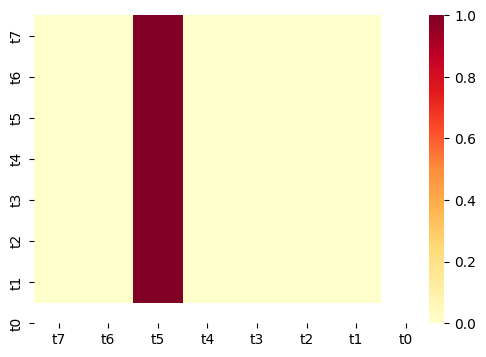

In [132]:
xticklb = timesteps
yticklb = timesteps
figure, axis = plt.subplots(1, 1)
figure.set_figheight(4)
figure.set_figwidth(6)
att_a=attention_scores_a[0,:,:]
sns.heatmap(att_a, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd",ax=axis)

In [134]:
tag_c="model_c"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag_c
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-3)

model.compile(optimizer="Adam", loss='mse', metrics=['mse','mae','mape'])
rnn_c = model.fit(yw_c, yt_c, batch_size=128, epochs=128,verbose=1,callbacks=[tensorboard_callback])
model.save(log_dir+'/model_{0}.keras'.format(tag_c))

Epoch 1/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1612.2545 - mae: 31.2322 - mape: 18.2869 - mse: 1612.2545
Epoch 2/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 722.4280 - mae: 21.8165 - mape: 12.7410 - mse: 722.4280
Epoch 3/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 626.9263 - mae: 19.8225 - mape: 11.8948 - mse: 626.9263
Epoch 4/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 611.1153 - mae: 19.0360 - mape: 11.6525 - mse: 611.1153
Epoch 5/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 618.4630 - mae: 18.6966 - mape: 11.6108 - mse: 618.4630
Epoch 6/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 619.6776 - mae: 18.6836 - mape: 11.6393 - mse: 619.6776
Epoch 7/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 606.9724 - mae: 18.6820 - mape: 11.5938 - mse: 606.9724
Epoch 8/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 600.4872 - mae: 18.6907 - mape: 11.5628 - mse: 600.4872
Epoch 9/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 601.5881 -

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


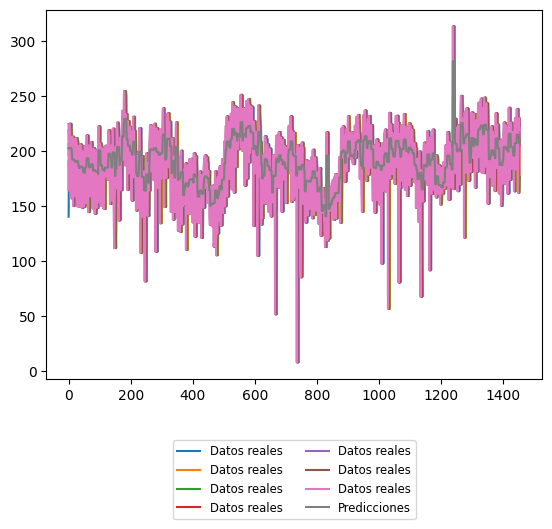

In [135]:
xw_c=[i for i in range(len(yw_c))]
yp_c=model.predict(yw_c)
plt.plot(xw_c, yw_c, label='Datos reales')
plt.plot(xw_c, yp_c, label='Predicciones')

plt.legend(fontsize='small', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)

plt.show()

In [136]:
attention_output_c,attention_scores_c=model.layers[4]([yw_c[:1].reshape(1,7,1),
                yw_c[:1].reshape(1,7,1),
                yw_c[:1].reshape(1,7,1)],
                return_attention_scores=True)

<Axes: >

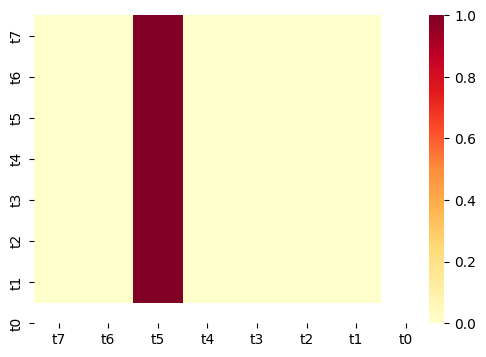

In [138]:
figure, axis = plt.subplots(1, 1)
figure.set_figheight(4)
figure.set_figwidth(6)
att_c=attention_scores_c[0,:,:]
sns.heatmap(att_c, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd",ax=axis)

In [139]:
tag_f="model_f"+datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = "logs/fit/" + tag_f
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
optimizer=Adam(learning_rate=1e-3)

model.compile(optimizer="Adam", loss='mse', metrics=['mse','mae','mape'])
rnn_f = model.fit(yw_f, yt_f, batch_size=128, epochs=128,verbose=1,callbacks=[tensorboard_callback])
model.save(log_dir+'/model_{0}.keras'.format(tag_f))

Epoch 1/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 59.5305 - mae: 4.7500 - mape: 277.2568 - mse: 59.5305
Epoch 2/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 50.5283 - mae: 4.1499 - mape: 230.0432 - mse: 50.5283
Epoch 3/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 45.3563 - mae: 3.8617 - mape: 214.7924 - mse: 45.3563
Epoch 4/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 42.8872 - mae: 3.7133 - mape: 196.3013 - mse: 42.8872
Epoch 5/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 43.4255 - mae: 3.6161 - mape: 183.4396 - mse: 43.4255
Epoch 6/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 43.6779 - mae: 3.6239 - mape: 185.4091 - mse: 43.6779
Epoch 7/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 42.4777 - mae: 3.6406 - mape: 181.0277 - mse: 42.4777
Epoch 8/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 42.3155 - mae: 3.6081 - mape: 175.0612 - mse: 42.3155
Epoch 9/128
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 42.5929 - mae: 3.5887 - mape

46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


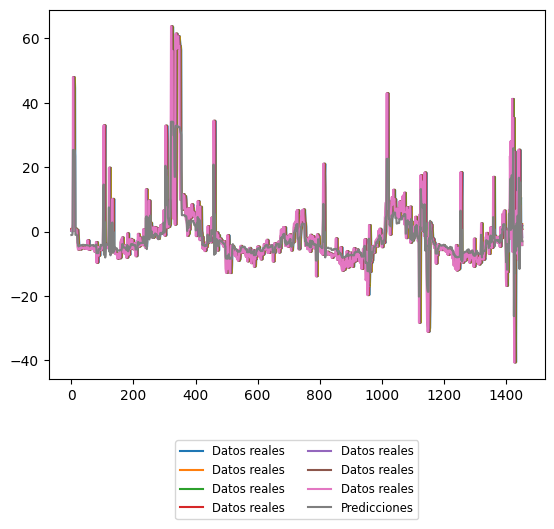

In [140]:
xw_f=[i for i in range(len(yw_f))]
yp_f=model.predict(yw_f)
plt.plot(xw_f, yw_f, label='Datos reales')
plt.plot(xw_f, yp_f, label='Predicciones')

plt.legend(fontsize='small', bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)

plt.show()

In [141]:
attention_output_f,attention_scores_f=model.layers[4]([yw_f[:1].reshape(1,7,1),
                yw_f[:1].reshape(1,7,1),
                yw_f[:1].reshape(1,7,1)],
                return_attention_scores=True)

<Axes: >

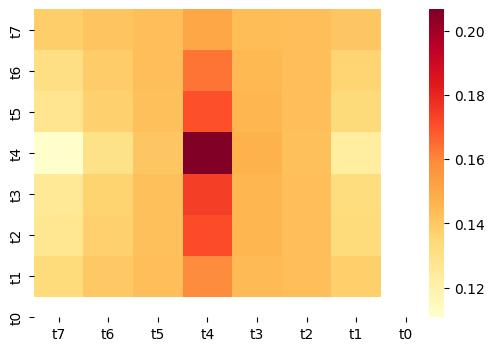

In [142]:
figure, axis = plt.subplots(1, 1)
figure.set_figheight(4)
figure.set_figwidth(6)
att_f=attention_scores_f[0,:,:]
sns.heatmap(att_f, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd",ax=axis)